### 사전 훈련된 가중치로 VGG16네트워크 로드하기

In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet') # 최상단의 완전 연결 분류기를 포함한다.

> 이미지를 VGG16모델이 인식할 수 있도록 변환해야 한다. 
### VGG16을 위해 이미지 전처리하기

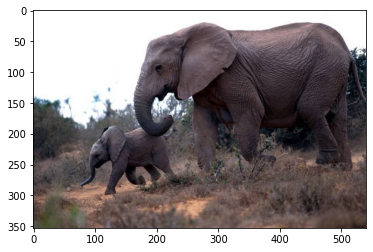

In [2]:
# 아프리카 코끼리1!!!
import matplotlib.pyplot as plt
import matplotlib.image as img

img_path = './datasets/elephant.jpg' # 이미지 경로

image = img.imread(img_path)
plt.imshow(image)
plt.show()

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np



img = image.load_img(img_path, target_size=(224, 224))
# 224 * 224 크기의 파이썬 이미징 라이브러리(PIL)객체로 반환된다.

x = image.img_to_array(img) # (224, 224, 3) 크기의 넘파이 float32 배열

x = np.expand_dims(x, axis=0) # 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 반환한다.

x = preprocess_input(x) # 데이터를 전처리한다.(채널별 컬러 정규화 수행)
# 이미지 채널을 RGB에서 BGR로 바꾸고 Imagenet 데이터셋에서 구한 채널별 평균값을 뺀다.

### 이미지에서 사전 훈련된 네트워크를 실행하고 예측 벡터를 이해하기 쉽게 디코딩한다.
> ```decode_predictions()```함수는 ImageNet 데이테셋에 대한 예측 결과에서 top매개변수에 지정된 수만큼 최상위 항목을 반환한다.

In [4]:
preds = model.predict(x)

In [5]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.5013029), ('n01871265', 'tusker', 0.47356877), ('n02504013', 'Indian_elephant', 0.025128162)]


### 예측 결과
* 1. 아프리카 코끼리(50%)
* 2. 투스커? 코끼리(47%)
* 3. 인도 코끼리(2%)

네트워크가 이 이미지가 아프리카 코끼리를 담고 있다고 인식했다!!! 예측 백터에서 최대로 활성화된 항목을 찾아보자.

In [6]:
np.argmax(preds[0])

386

### 이미지에서 가장 아프리카 코끼리 같은 부위를 시각화하기 위해 Grad_CAM 설정하기
> [:, :. ?]같은거 많이 쓰이던데, 이거는 배열인덱싱으로 다차원에서 콜론을 기준으로 행과 열을 분리하는 것이다.


In [21]:
from keras import backend as K
import tensorflow as tf

african_elephant_output = model.output[:, 386] # 예측 벡터의 아프리카 코끼리 항목

last_conv_layer = model.get_layer('block5_conv3')
# VGG16의 마지막 함성곱 층인 block5_conv3 층의 특성맵
with tf.GradientTape() as gtape:
    grads = gtape.gradient(african_elephant_output, last_conv_layer.output)
    
    
    # 여기 왜 오류나고!!!!!!!!!!!!!!!!!!!!!!! 고쳐 봐도 안된다. 개빡치는 
# block5_conv3의 특성맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 특성 맵 채널별 그래디언트 평균값이 담긴 (512, )크기의 벡터

iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])
# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grad와 block5_conv3의 특성 맵 출력을 구한다.

pooled_grads_value, conv_layer_output_value = iterate[x]
# 두마리의 코끼리가 있는 샘플 이미지를 주입라고 2개의 넘파이 배열을 얻는다.

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # 아프리카 코끼리 클래스에 대한 채널의 중요도를 특성 맵 배열의 채널에 곱한다.
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
# 만들어진 특성맵에서 채널 축을 따라 평균한 값이 활성화의 히트맵이다.

AttributeError: 'KerasTensor' object has no attribute '_id'

### 히트맵 후처리

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### 원본 이미지에 히트맵 덧붙이기

In [ ]:
import cv2


img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경한다.
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다
cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

### 이 시각화 기법은 2개의 중요한 질문에 대한 답을준다.
* 왜 네트워크가 이 이미지에 아프리카 코끼리가 있다고 생각하는가??
* 아프리카 코끼리가 사진 어디에 있는가??